In [19]:
#learning machine learning using the MNIST digit recognition data set.
#based on the "tutorial" here: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical #convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

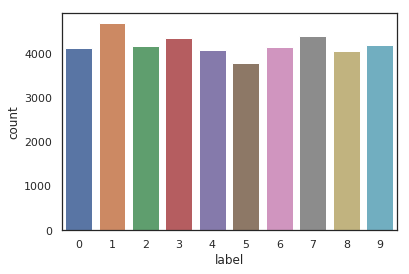

In [32]:
#load data
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

#make the label column into the Y_train
Y_train = train["label"]

#drop the label column from X
X_train = train.drop(labels = ["label"], axis = 1)

# delete the variable train to free up some space and we don't need it anymore
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

#print(X_train.shape) can print the top rows and the size if you want.
#X_train.head()

In [33]:
#check for null or mising values in train set
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [34]:
#do the same for the test set
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [35]:
#no issues (no nulls/missing values)

In [36]:
#Normalization
#CNN converge faster on 0...1 than 0...255; that and we can eliminate any differences in the images colorization
X_train = X_train / 255.0
test = test / 255.0

In [37]:
#reshape the train and test
#the train and test images were stored as 1D vectors of 784 values. We'll reshape them until 3D matrices so 28x28x1 3D vectors.
#the last dimension of the new reshaped matrix refers to the channels. Since we've grey-scaled there's only 1 channel but if we had used color (3 channels), the matrix would have 28x28x3

X_train = X_train.values.reshape(-1, 28, 28, 1) #-1 means that we want python to figure out that dimension on it's own
test = test.values.reshape(-1, 28, 28, 1)

In [38]:
#label encoding
#one-hot vector -> convert labels into one hot vectors such that for example a 2 is [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Y_train = to_categorical(Y_train, num_classes = 10) #there are 10 possible values for the label

In [39]:
#split training set in two: a training set and a validation set
#set a random seed
random_seed = 2

In [40]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

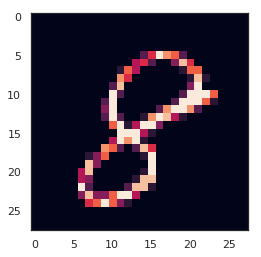

In [42]:
#plot some examples
g = plt.imshow(X_train[0][:,:,0])

In [46]:
#CNN
#CNN architechture set as the following: Input -> [[Conv2D->relu]x2 ->MaxPool2D -> Dropout]x2 ->Flatten -> Dense -> Dropout ->Output

model = Sequential()

#First layer, 32 filters where each filter transforms part of the image, that part of the image is set by the kernal
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
#Second layer, 32 filters where each filter transforms part of the image, that part of the image is set by the kernal
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
#Third layer, pooling where two neighboring pixels are compared and the maximum value is picked. 
#This reduces computational cost and reduces overfitting. Bigger pooling size, bigger impact.
model.add(MaxPool2D(pool_size = (2,2)))
#Dropout for regularization
model.add(Dropout(0.25))

#Above layers again
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten()) #converts final feature map to one single 1D vector and combines the previous layers
model.add(Dense(256, activation = 'relu')) #an artifical neural network
model.add(Dropout(0.5)) 
model.add(Dense(10, activation = 'softmax')) #outputs distribution of probability of each class

W0923 12:07:44.715214 140510614759232 deprecation_wrapper.py:119] From /home/karen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0923 12:07:44.720539 140510614759232 deprecation_wrapper.py:119] From /home/karen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0923 12:07:44.738081 140510614759232 deprecation.py:506] From /home/karen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
#instead of using Stochastic Gradient Descent as our optimizer (for the cost function), this tutorial is going to use RSMprop.

In [49]:
#Define the optimizer"
optimizer = RMSprop(lr = 0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [52]:
#compile the model
#categorical_crossentropy is used because we are trying classify on 2 categories/class
#metric function of accuracy is used to evalute the performace of the model, 
#similar to the loss function, except that the metric evalutions are only used when training the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

W0923 12:15:25.820435 140510614759232 deprecation_wrapper.py:119] From /home/karen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [53]:
#use an annealing method on the learning rate - change the learning rate as the model learns so that 
#the learning rate decreases over time. this helps to find the global minimum quickly
#set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(montitor ='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [54]:
#then to take advantage of this, we'll decrease the LR every X steps (epochs) if it is necessary (the accuracy isn't good enough after 3 steps)
epochs=1 #turn epochs to 30 to get 0.9967 accuracy (?)
batch_size = 86

In [59]:
#data augumentation (expand the dataset artifically)
datagen = ImageDataGenerator(
            featurewise_center=False #set input mean to 0 over the dataset
            ,samplewise_center=False #set each sample mean to 0
            ,featurewise_std_normalization=False #divide inputs by std of the data set
            ,samplewise_std_normalization=False #divide each input by its std
            ,zca_whitening=False #apply ZCA whitening
            ,rotation_range=10 #randomly rotate images in the range (degrees, 0 up to 180)
            ,zoom_range=0.1 #randomly zoom image
            ,width_shift_range=0.1 #randomly shift images horizontally (fraction of total width)
            ,height_shift_range=0.1 #randomly shift images vertically (fraction of total height)
            ,horizontal_flip=False #horizontal flip = no
            ,vertical_flip=False #vertical flip = no
            )
datagen.fit(X_train)

In [61]:
#fit the model
#fit_generator allows you to augument the data parallel to running the model
history=model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size), 
                            epochs=epochs #arbitrary cutt-off/"one pass over the entire dataset"
                            ,validation_data = (X_val, Y_val)
                           ,verbose =2
                           ,steps_per_epoch=X_train.shape[0] //batch_size
                           ,callbacks=[learning_rate_reduction]) #run this at the end of every epoch (in this case
                            #redefine the learning rate after each pass over the data)

Epoch 1/1
 - 255s - loss: 0.2422 - acc: 0.9268 - val_loss: 0.0621 - val_acc: 0.9824


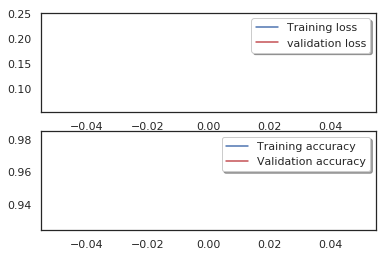

In [65]:
#evaluate the model
#training and validation curves
#plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

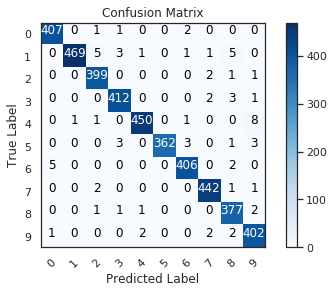

In [68]:
#plot a confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
            cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
            
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
#predict values from validation dataset
Y_pred = model.predict(X_val)
#convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
#convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1)
#compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
#plot
plot_confusion_matrix(confusion_mtx, classes = range(10))